# Szeregi czasowe

Antoni Pięta

Jaub Ziarko

In [1]:
from pandas import read_csv
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Ładowanie datasetu

In [2]:
data_filename = 'result3.csv'
dataset = read_csv(data_filename)

### Klumny i przykładowane dane z datasetu

In [3]:
dataset.head(7)

,datetime_from,avg(pm10),avg(humidity)
0,2020-04-20 00:00:00,26.2025,68.8590
1,2020-04-20 01:00:00,26.4570,73.9560
2,2020-04-20 02:00:00,26.8135,77.6065
3,2020-04-20 03:00:00,25.6330,79.6785
4,2020-04-20 04:00:00,28.3240,79.9945
5,2020-04-20 05:00:00,26.5280,77.7310
6,2020-04-20 06:00:00,23.4925,72.0375


### Informacje o datasecie

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 3 columns):
datetime_from    264 non-null object
avg(pm10)        264 non-null float64
avg(humidity)    264 non-null float64
dtypes: float64(2), object(1)
memory usage: 6.3+ KB


### Dodajemy kolumnę, która ma być używana do przewidywana - `actual`

In [5]:
steps = -1
dataset_for_prediction = dataset.copy()
dataset_for_prediction['actual'] = dataset_for_prediction['avg(pm10)'].shift(steps)

In [6]:
dataset_for_prediction.tail(15)

,datetime_from,avg(pm10),avg(humidity),actual
249,2020-04-30 09:00:00,46.247391,81.591304,43.043913
250,2020-04-30 10:00:00,43.043913,75.183478,40.766087
251,2020-04-30 11:00:00,40.766087,69.480435,37.980435
252,2020-04-30 12:00:00,37.980435,63.239565,35.386522
253,2020-04-30 13:00:00,35.386522,58.739565,36.052174
254,2020-04-30 14:00:00,36.052174,55.763913,37.265652
255,2020-04-30 15:00:00,37.265652,56.082174,39.158696
256,2020-04-30 16:00:00,39.158696,60.063043,37.452609
257,2020-04-30 17:00:00,37.452609,65.129130,37.653043
258,2020-04-30 18:00:00,37.653043,70.024783,41.697391


### Usuwamy wiersze z wartościami NaN

In [7]:
dataset_for_prediction=dataset_for_prediction.dropna()
dataset_for_prediction.tail(15)

,datetime_from,avg(pm10),avg(humidity),actual
248,2020-04-30 08:00:00,52.360435,87.122609,46.247391
249,2020-04-30 09:00:00,46.247391,81.591304,43.043913
250,2020-04-30 10:00:00,43.043913,75.183478,40.766087
251,2020-04-30 11:00:00,40.766087,69.480435,37.980435
252,2020-04-30 12:00:00,37.980435,63.239565,35.386522
253,2020-04-30 13:00:00,35.386522,58.739565,36.052174
254,2020-04-30 14:00:00,36.052174,55.763913,37.265652
255,2020-04-30 15:00:00,37.265652,56.082174,39.158696
256,2020-04-30 16:00:00,39.158696,60.063043,37.452609
257,2020-04-30 17:00:00,37.452609,65.129130,37.653043


### Ustawiamy date jako index 

In [8]:
dataset_for_prediction['datetime_from'] = pd.to_datetime(dataset_for_prediction['datetime_from'])
dataset_for_prediction.index = dataset_for_prediction['datetime_from']
dataset_for_prediction

,datetime_from,avg(pm10),avg(humidity),actual
datetime_from,,,,
2020-04-20 00:00:00,2020-04-20 00:00:00,26.202500,68.859000,26.457000
2020-04-20 01:00:00,2020-04-20 01:00:00,26.457000,73.956000,26.813500
2020-04-20 02:00:00,2020-04-20 02:00:00,26.813500,77.606500,25.633000
2020-04-20 03:00:00,2020-04-20 03:00:00,25.633000,79.678500,28.324000
2020-04-20 04:00:00,2020-04-20 04:00:00,28.324000,79.994500,26.528000
...,...,...,...,...
2020-04-30 18:00:00,2020-04-30 18:00:00,37.653043,70.024783,41.697391
2020-04-30 19:00:00,2020-04-30 19:00:00,41.697391,73.581739,48.421739
2020-04-30 20:00:00,2020-04-30 20:00:00,48.421739,77.083478,51.913913


### Rysowanie wykresów na podstawie danych

PM10

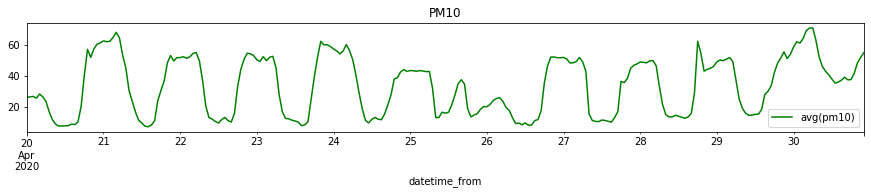

In [9]:
dataset_for_prediction['avg(pm10)'].plot(color='green', figsize=(15, 2))
plt.legend(['avg(pm10)'])
plt.title('PM10')
plt.show()

Humidity

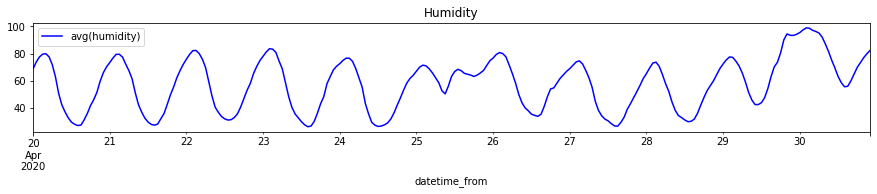

In [10]:
dataset_for_prediction['avg(humidity)'].plot(color='blue', figsize=(15, 2))
plt.legend(['avg(humidity)'])
plt.title('Humidity')
plt.show()

### Normalizacja danych wejściowych oraz target features

In [11]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction[['avg(pm10)', 'avg(humidity)']])
scaled_input = pd.DataFrame(scaled_input)
X = scaled_input
X

,0,1
0,0.297815,0.585343
1,0.301809,0.655661
2,0.307404,0.706022
3,0.288877,0.734607
4,0.331110,0.738967
...,...,...
258,0.477523,0.601426
259,0.540996,0.650498
260,0.646530,0.698807
261,0.701338,0.737975


In [12]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['actual']])
scaler_output = pd.DataFrame(scaler_output)
y = scaler_output
y

,0
0,0.301809
1,0.307404
2,0.288877
3,0.331110
4,0.302923
...,...
258,0.540996
259,0.646530
260,0.701338
261,0.749812


### Zmiana nazw kolumn dla danych wejściowych i targetów

In [13]:
X.rename(columns={0: 'pm10', 1: 'humidity'}, inplace=True)
y.rename(columns={0: 'pm10 prediction'}, inplace=True)
y.index=dataset_for_prediction.index
X.index=dataset_for_prediction.index

In [14]:
X

,pm10,humidity
datetime_from,,
2020-04-20 00:00:00,0.297815,0.585343
2020-04-20 01:00:00,0.301809,0.655661
2020-04-20 02:00:00,0.307404,0.706022
2020-04-20 03:00:00,0.288877,0.734607
2020-04-20 04:00:00,0.331110,0.738967
...,...,...
2020-04-30 18:00:00,0.477523,0.601426
2020-04-30 19:00:00,0.540996,0.650498
2020-04-30 20:00:00,0.646530,0.698807


In [15]:
y

,pm10 prediction
datetime_from,
2020-04-20 00:00:00,0.301809
2020-04-20 01:00:00,0.307404
2020-04-20 02:00:00,0.288877
2020-04-20 03:00:00,0.331110
2020-04-20 04:00:00,0.302923
...,...
2020-04-30 18:00:00,0.540996
2020-04-30 19:00:00,0.646530
2020-04-30 20:00:00,0.701338


### Podział datasetu na dane treningowe i testowe

In [16]:
train_size = int(len(dataset) * 0.90)
test_size = int(len(dataset)) - train_size

train_X, train_y = X[:train_size].dropna(), y[:train_size].dropna()
test_X, test_y = X[train_size:].dropna(), y[train_size:].dropna()

### Dekompoyzcja szeregu czasowego na trend, sezonowość/cykliczność, szum

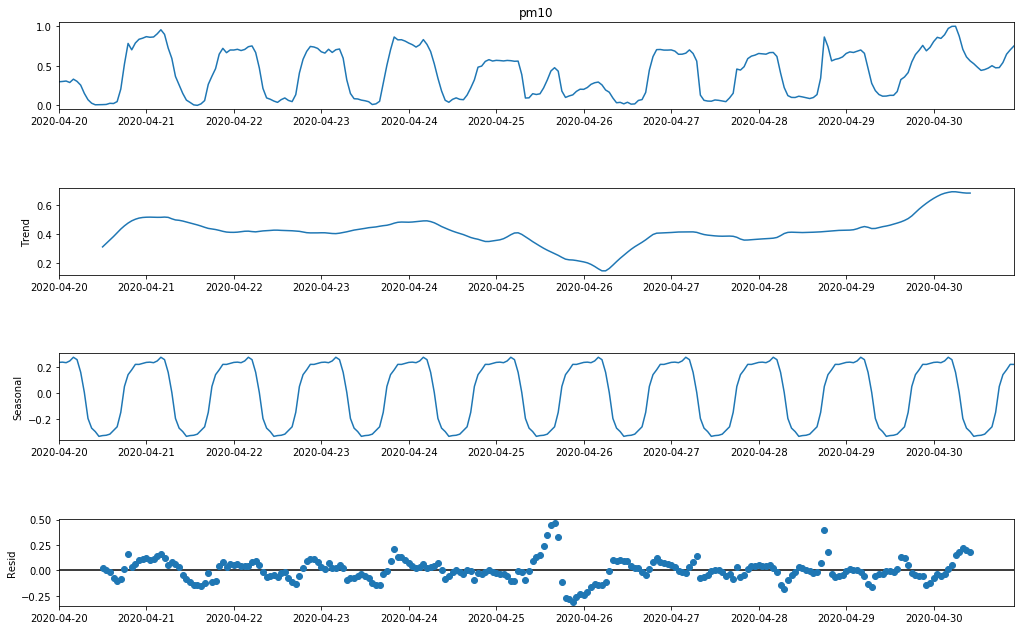

In [17]:
seas_d=sm.tsa.seasonal_decompose(X['pm10'],model='add',period=24);
fig=seas_d.plot()
fig.set_figheight(10)
fig.set_figwidth(16)
plt.show()

Additive model = Trend + Seasonality + Random Noise

### Sprawdzamy stacjonarość danych poprzez Augmented Dickey Fuller(ADF) test

Jeśli sprawimy że dane będą stacjonare to model będzie wykonywał przewidywania na podstawie tego że średnia oraz wariancją będą takie są przez przyszłe okresy.

In [18]:
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [19]:
y_test=y['pm10 prediction'][:train_size].dropna()
test_adf(y_test, 'pm10')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary pm10


### Dane stacjonarne - różnicowanie

In [20]:
test_adf(y_test.diff(), 'pm10')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary pm10


### Budowanie modelu

ACF plot: wykres słupkowy współczynników korelacji między szeregiem czasowym a jego własnym opóźnieniem

PACF plot: wykres słupkowy współczynników częściowej korelacji między szeregiem czasowym a jego własnym opóźnieniem

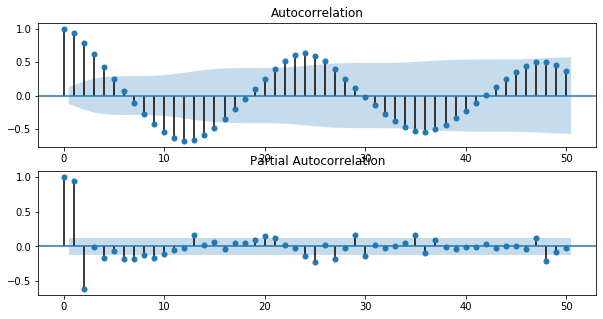

In [21]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=50, ax=ax[1])
plt.show()

### Funkcja auto_arima która dobiera najlepsze parametry modelu ARIMA do szeregu czasowego.

Losowo wybiera i sprawdza kolejne paraemtry dobierając w ten sposób te najlepsze. Próbuje zminimalizować partykę AIC (Akaike Information Criterion) - dobiera parametry dla ktorych jest najmniejsza.

In [22]:
step_wise=auto_arima(train_y, 
 exogenous= train_X,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-524.342, BIC=-503.559, Time=0.268 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-514.343, BIC=-500.487, Time=0.046 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-519.701, BIC=-502.382, Time=0.110 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-526.173, BIC=-508.854, Time=0.136 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-516.333, BIC=-505.942, Time=0.059 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=-524.404, BIC=-503.621, Time=0.221 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=-526.000, BIC=-501.753, Time=0.329 seconds
Total fit time: 1.174 seconds


In [23]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  237
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 268.087
Date:                Mon, 04 May 2020   AIC                           -526.173
Time:                        11:00:12   BIC                           -508.854
Sample:                    04-20-2020   HQIC                          -519.192
                         - 04-29-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.008      0.089      0.929      -0.014       0.016
pm10          -0.0466      0.141     -0.330      0.742      -0.324       0.230
humidity       0.8924      0.168      5.297      0.000       0.562       1.223
ma.L1          0.4357      0.147      2.960      0.003       0.147       0.724
sigma2         0.0060      0.000     18.651      0.000       0.005       0.007
===================================================================================
Ljung-Box (Q):                       74.42   Jarque-Bera (JB):               313.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.87   Skew:                            -0.08
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Zasugerowany został SARIMAX oraz wartości dla p,d,q wynoszące odpowiednio 0,1,1.

### Trenowanie modelu

In [24]:
model = SARIMAX(train_y, exog=train_X, order=(0,1,1), enforce_invertibility=False, enforce_stationarity=False)

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [25]:
results = model.fit()

### Predykcja

predict()

podajemy koniec oraz początek wraz ze zmienną exog, na podstawie której dokonana zostanie predykcja

In [26]:
predictions= results.predict(start=train_size, end=train_size+test_size+(steps)-1,exog=test_X)

### Stworzenie wykresu dla uzyskanej predykcji 

In [27]:
act= pd.DataFrame(scaler_output.iloc[train_size:, 0])

In [28]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['actual'] = act['pm10 prediction']
predictions.rename(columns={0:'Pred'}, inplace=True)

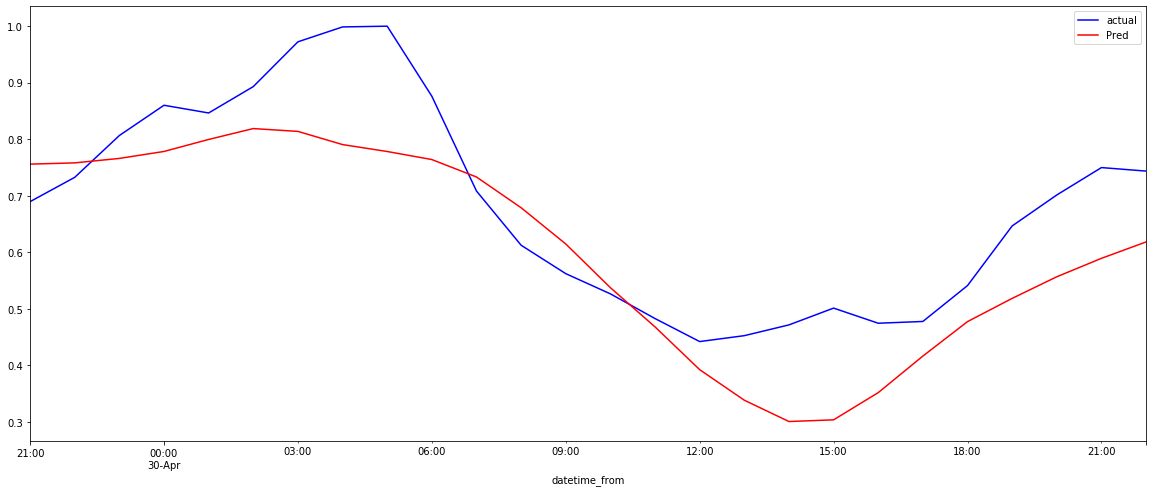

In [29]:
predictions['actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

### Ewaluacja błędu

In [30]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions['Pred'], predictions['actual'])
error

0.11519513584109184

### Skalowanie do oryginalnych wartości

In [31]:
trainPredict = sc_out.inverse_transform(predictions[['Pred']])
testPredict = sc_out.inverse_transform(predictions[['actual']])